# Assignment 1: k-nearest neighbors

Only use the already imported libraries `numpy` and `matplotlib.pyplot` for the assignment. Do not import any other library. 

In [281]:
# Load required packages and dataset. Do not modify.
import matplotlib.pyplot as plt
import numpy as np


def load_iris_dataset():
    from sklearn import datasets
    iris = datasets.load_iris()
    X = iris.data
    y = iris.target
    return X, y
    
X, y = load_iris_dataset()


## Task 1: Visualization and Preprocessing

1) Explain the content of the dataset in few words. What are the input features? What is the classification target? Check out: [https://en.wikipedia.org/wiki/Iris_flower_data_set](https://en.wikipedia.org/wiki/Iris_flower_data_set).


It is a analysis of Iris setosa, Iris virginica and Iris versicolor. From each of them 50 samples are taken.
There are two features for the length and the width of the sepals and two features for the length and the width of the petals in centimeters.

The classification target is distinguishing the species from each other.

2) Compute and print the following statistics about the dataset:
  - Number of samples
  - Number of samples per class
  - Mean and standard deviation for each input feature


In [282]:
number_of_samples = len(y)

number_of_samples_0 = np.bincount(y)[0]
number_of_samples_1 = np.bincount(y)[1]
number_of_samples_2 = np.bincount(y)[2]

mean = np.mean(X, axis=0)
standard_deviation = np.std(X, axis=0)

3) Visualize the variables Sepal length and Petal length in a scatter plot (Sepal length on the x-axis, petal length on the y-axis). Color each point of the plot according to its class.

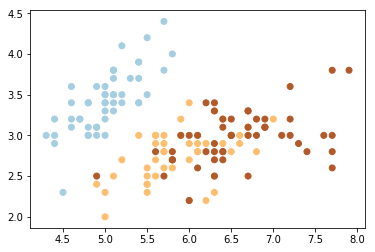

In [283]:
plt.scatter(X[:,0], X[:,1], c=y, cmap=plt.cm.get_cmap(name="Paired"))
plt.show()

4) Split the dataset randomly into training and test data. 70% of data should be used for training and 30% should be used for testing. Implement the function `train_test_split`. Do not modify the interface of the function.

In [284]:
def train_test_split(X, y):
    """
    Returns X_train, X_test, y_train, y_test, 
        where X_train and X_test are the input features of the training and test set,
        and y_train and y_test are the class labels of the training and test set.
    """
    train, test = np.split(np.random.permutation(np.c_[X, y]), [int(len(y) * 0.7)])


    return train[:, :-1], test[:, :-1], train[:, -1].astype(int), test[:, -1].astype(int)

X_train, X_test, y_train, y_test = train_test_split(X, y)


assert (X_train.shape[0] + X_test.shape[0]) == X.shape[0]
assert (y_train.shape[0] + y_test.shape[0]) == y.shape[0]
assert X_train.shape[1] == X_test.shape[1]


5) kNN uses a distance measure to identify close neighbors. If the input features are not of the same scale, the distance is not as meaningful, which can negatively impact classification performance. Perform min-max scaling (i.e. scale the values of the input features in such a way that their range is from 0 to 1) on the training and test data. Remember that you should only use information from the training data to perform the scaling on both data sets.

In [285]:
def min_max(x_train, x_toscale):
    
    X_scaled = (x_toscale - x_train.min(axis=0)) / (x_train.max(axis=0) - x_train.min(axis=0))    
    return X_scaled  

X_test = min_max(X_train, X_test)
X_train = min_max(X_train, X_train)

## Task 2: k-nearest neighbors

**For B.Sc. Data Science:**  
Implement the kNN algorithm with uniform weighting and arbitrary `k`. Fill out the `predict` method of class `KNearestNeighborsClassifier`. 

Use Euclidean distance to determine the nearest neighbors.
You can ignore the optional parameter `distance_metric`, which is provided as a field in the kNN class.

**For everyone else:**  
Implement the kNN algorithm with distance-based weighting and arbitrary `k`.
Fill out the `predict` method of class `KNearestNeighborsClassifier`.

The parameter `distance_metric` will either contain the string `uniform` or a function. If the value is `uniform`, the classifier should use the Euclidean distance for determining nearest neighbors and uniform weighting. If the value is a function, the classifier should use the function as distance metric and perform distance-weighted classification. An example distance metric is provided with `euclidean_distance`.

In [286]:
class KNearestNeighbors(object):
    def __init__(self, k, distance_metric='uniform'):
        self.k = k
        self.distance_metric = distance_metric
        
    def fit(self, X, y):
        """
        This functions saves the training data to be used during the prediction.
        """
        self.X = X
        self.y = y
    
    def predict(self, X):
        """
        Returns a vector of shape (n,) if X has shape (n,d), 
        where n is the number of samples and d is the number of features.
        """
        y_pred = []
               
        for sample in X:            
            # entry of form [index, distance, label, weight]
            distance = []
            for i in range(len(self.X)):                
                dist = euclidean_distance(self.X[i], sample) if self.distance_metric == 'uniform' else self.distance_metric(self.X[i],sample)                
                distance.append([i,dist,int(self.y[i]), 0])                
            distance.sort(key=lambda x: x[1])
            distance = distance[:self.k]

            # Add weights depending on distance-rank (harmonic row)
            harmonic_row = [float(1)/float(i+1) for i in range(self.k)]            
            for i in range(self.k):                
                distance[i][3] = sum(harmonic_row[i:]) / self.k                           
                

            if self.distance_metric == 'uniform':                
                occurences = np.bincount(np.array(distance)[:,2].astype(int))
                y_pred.append(np.argmax(occurences))
            else :
                # Determine label by adding weights of each label
                labels = np.unique(np.array(distance)[:,2].astype(int))
                weights = []                
                for lb in labels: 
                    weight = 0                                      
                    for i in range(self.k):
                        if (distance[i][2] == lb): weight = weight + distance[i][3] 
                    weights.append(weight)                
                y_pred.append(labels[np.argmax(weights)])              
        
        return np.array(y_pred)        

    
def euclidean_distance(x1, x2):
    """
    Given vectors x1 and x2 with shape (n,) returns distance between vectors as float.
    """
    return np.sqrt(np.sum((x1 - x2)*(x1 - x2)))



## Task 3: Evaluation

1) Implement functions to compute precision, recall and F1-score. `y_pred` and `y_true` are the vectors of predicted and true class labels respectively with shape `(n,)`, where `n` is the number of samples. Each function should return a float containing the corresponding score.

In [287]:
def precision(y_pred, y_true):
    labels = np.unique(y_true)    
    weighted_precision = 0.
    for lb in labels:        
        true_p = float(len(y_pred[y_true == lb][y_pred[y_true == lb] == lb]))
        prec = float(true_p / np.bincount(y_pred)[lb])
        weighted_precision = weighted_precision + prec * np.bincount(y_true)[lb]           
    return weighted_precision / len(y_true)
    

def recall(y_pred, y_true):
    labels = np.unique(y_true)
    weighted_recall = 0.
    for lb in labels:
        true_p = float(len(y_pred[y_true == lb][y_pred[y_true == lb] == lb]))
        rec = float(true_p / (true_p + (np.bincount(y_true)[lb] - true_p)))        
        weighted_recall = weighted_recall + rec * np.bincount(y_true)[lb]
    return weighted_recall / len(y_true)

def f1score(y_pred, y_true):
    labels = np.unique(y_true)
    weighted_f1 = 0.
    for lb in labels:
        true_p = float(len(y_pred[y_true == lb][y_pred[y_true == lb] == lb]))
        prec = float(true_p / np.bincount(y_pred)[lb])
        rec = float(true_p / (true_p + (np.bincount(y_true)[lb] - true_p)))
        
        weighted_f1 = weighted_f1 + (2*float(rec * prec)/(float(rec) + float(prec))) * np.bincount(y_true)[lb]
        
    return weighted_f1 / len(y_true)   

2) Evaluate the performance of kNN with uniform weighting on the Iris dataset for `k=1,3,5`. Train each of the `3` classifiers on the training data from Task 1. Perform the predictions on both the training and test data. Then compute precision, recall, and F1-score for each model and for both training and test data. Print all scores per model. What do you observe?

**For all students other than B.Sc. Data Science:** 
Evaluate the kNN classifier with Euclidean distance-weighting. Compare the performance to uniform-weighting. How does the performance change compared to uniform weighting for each `k`?

In [288]:
# Uniform weighting
kNN1 = KNearestNeighbors(1)
kNN3 = KNearestNeighbors(3)
kNN5 = KNearestNeighbors(5)
kNN1.fit(X_train,y_train)
kNN3.fit(X_train,y_train)
kNN5.fit(X_train,y_train)

y_test_pred_1 = kNN1.predict(X_test)
y_train_pred_1 = kNN1.predict(X_train)
y_test_pred_3 = kNN3.predict(X_test)
y_train_pred_3 = kNN3.predict(X_train)
y_test_pred_5 = kNN5.predict(X_test)
y_train_pred_5 = kNN5.predict(X_train)

#1NN test data
prec_1 = precision(y_test_pred_1, y_test)
rec_1 = recall(y_test_pred_1, y_test)
f1_1 = f1score(y_test_pred_1, y_test)

#1NN training data
prec_1_train = precision(y_train_pred_1, y_train)
rec_1_train = recall(y_train_pred_1, y_train)
f1_1_train = f1score(y_train_pred_1, y_train)

#3NN test data
prec_3 = precision(y_test_pred_3, y_test)
rec_3 = recall(y_test_pred_3, y_test)
f1_3 = f1score(y_test_pred_3, y_test)

#5NN training data
prec_3_train = precision(y_train_pred_3, y_train)
rec_3_train = recall(y_train_pred_3, y_train)
f1_3_train = f1score(y_train_pred_3, y_train)

#5NN test data
prec_5 = precision(y_test_pred_5, y_test)
rec_5 = recall(y_test_pred_5, y_test)
f1_5 = f1score(y_test_pred_5, y_test)

#5NN training data
prec_5_train = precision(y_train_pred_5, y_train)
rec_5_train = recall(y_train_pred_5, y_train)
f1_5_train = f1score(y_train_pred_5, y_train)

print("1NN Test Data - Precision: {} , Recall: {} , F1 Score: {}".format(prec_1,rec_1,f1_1))
print("1NN Training Data - Precision: {} , Recall: {} , F1 Score: {}".format(prec_1_train,rec_1_train,f1_1_train))

print("3NN Test Data - Precision: {} , Recall: {} , F1 Score: {}".format(prec_3,rec_3,f1_3))
print("3NN Training Data - Precision: {} , Recall: {} , F1 Score: {}".format(prec_3_train,rec_3_train,f1_3_train))

print("5NN Test Data - Precision: {} , Recall: {} , F1 Score: {}".format(prec_5,rec_5,f1_5))
print("5NN Training Data - Precision: {} , Recall: {} , F1 Score: {}\n".format(prec_5_train,rec_5_train,f1_5_train))

#distance-based weighting
kNN1 = KNearestNeighbors(1,euclidean_distance)
kNN3 = KNearestNeighbors(3,euclidean_distance)
kNN5 = KNearestNeighbors(5,euclidean_distance)
kNN1.fit(X_train,y_train)
kNN3.fit(X_train,y_train)
kNN5.fit(X_train,y_train)

y_test_pred_1 = kNN1.predict(X_test)
y_train_pred_1 = kNN1.predict(X_train)
y_test_pred_3 = kNN3.predict(X_test)
y_train_pred_3 = kNN3.predict(X_train)
y_test_pred_5 = kNN5.predict(X_test)
y_train_pred_5 = kNN5.predict(X_train)

#1NN test data
prec_1 = precision(y_test_pred_1, y_test)
rec_1 = recall(y_test_pred_1, y_test)
f1_1 = f1score(y_test_pred_1, y_test)

#1NN training data
prec_1_train = precision(y_train_pred_1, y_train)
rec_1_train = recall(y_train_pred_1, y_train)
f1_1_train = f1score(y_train_pred_1, y_train)

#3NN test data
prec_3 = precision(y_test_pred_3, y_test)
rec_3 = recall(y_test_pred_3, y_test)
f1_3 = f1score(y_test_pred_3, y_test)

#5NN training data
prec_3_train = precision(y_train_pred_3, y_train)
rec_3_train = recall(y_train_pred_3, y_train)
f1_3_train = f1score(y_train_pred_3, y_train)

#5NN test data
prec_5 = precision(y_test_pred_5, y_test)
rec_5 = recall(y_test_pred_5, y_test)
f1_5 = f1score(y_test_pred_5, y_test)

#5NN training data
prec_5_train = precision(y_train_pred_5, y_train)
rec_5_train = recall(y_train_pred_5, y_train)
f1_5_train = f1score(y_train_pred_5, y_train)

print("1NN Test Data - Precision: {} , Recall: {} , F1 Score: {}".format(prec_1,rec_1,f1_1))
print("1NN Training Data - Precision: {} , Recall: {} , F1 Score: {}".format(prec_1_train,rec_1_train,f1_1_train))

print("3NN Test Data - Precision: {} , Recall: {} , F1 Score: {}".format(prec_3,rec_3,f1_3))
print("3NN Training Data - Precision: {} , Recall: {} , F1 Score: {}".format(prec_3_train,rec_3_train,f1_3_train))

print("5NN Test Data - Precision: {} , Recall: {} , F1 Score: {}".format(prec_5,rec_5,f1_5))
print("5NN Training Data - Precision: {} , Recall: {} , F1 Score: {}".format(prec_5_train,rec_5_train,f1_5_train))



14.0
1.0
16.0
0.842105263158
12.0
1.0
36.0
1.0
34.0
1.0
35.0
1.0
14.0
1.0
16.0
0.888888888889
13.0
1.0
36.0
1.0
33.0
0.916666666667
32.0
0.969696969697
14.0
1.0
16.0
0.941176470588
14.0
1.0
36.0
1.0
33.0
0.916666666667
32.0
0.969696969697
1NN Test Data - Precision: 0.943859649123 , Recall: 0.933333333333 , F1 Score: 0.932486772487
1NN Training Data - Precision: 1.0 , Recall: 1.0 , F1 Score: 1.0
3NN Test Data - Precision: 0.96049382716 , Recall: 0.955555555556 , F1 Score: 0.955275443511
3NN Training Data - Precision: 0.962914862915 , Recall: 0.961904761905 , F1 Score: 0.961888755502
5NN Test Data - Precision: 0.97908496732 , Recall: 0.977777777778 , F1 Score: 0.977731336352
5NN Training Data - Precision: 0.962914862915 , Recall: 0.961904761905 , F1 Score: 0.961888755502

14.0
1.0
16.0
0.842105263158
12.0
1.0
36.0
1.0
34.0
1.0
35.0
1.0
14.0
1.0
16.0
0.842105263158
12.0
1.0
36.0
1.0
34.0
1.0
35.0
1.0
14.0
1.0
16.0
0.888888888889
13.0
1.0
36.0
1.0
34.0
0.944444444444
33.0
1.0
1NN Test Data

1NN achieves perfect results on the training data, but has the least precise results on the training data.
5NN achieves the best results on the test data.

When using Euclidean distance-weighting the performance decreases for all k.


3) Explain why kNN with `k=1` achieves perfect results on the training data. Why is it not the best model?

k=1 achieves the perfect result on the training data because we only pick the 1-nearest point.
1KK has the least amount of generalization, and has therefore a high sensitivity regarding outliers.
This leads to bad performance on new data.
